# Imports

In [1]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os
import time
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import files
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Will use CPU instead.")

# Set device
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

GPU available: True
Number of GPUs: 1
GPU 0: Tesla T4
Using device: 0


# Dataset Download Section

In [4]:
rf = Roboflow(api_key="OOMi0m3PhpE0bSmlr5rx")
project = rf.workspace("luigui-andre-cerna-grados-dpsrr").project("clasificacion-de-mangos")
version = project.version(16)

# Retry mechanism with error handling
retries = 3
for attempt in range(retries):
    try:
        dataset = version.download("yolov12")
        break  # Exit loop if successful
    except ConnectionError as e:
        print(f"Download attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print(f"Retrying in 5 seconds...")
            time.sleep(5)  # Wait before retrying
        else:
            print("Maximum retries reached. Download failed.")
            raise  # Re-raise the exception after max retries

# Rename the dataset folder to a more manageable name
!mv "/content/Clasificación-de-mangos-16" "/content/mango_dataset"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Clasificación-de-mangos-16 in yolov12:: 100%|██████████| 4004/4004 [00:01<00:00, 2502.93it/s]


# Data Preprocessing Section

Starting dataset preprocessing...
Training set: 1529 images
Validation set: 65 images


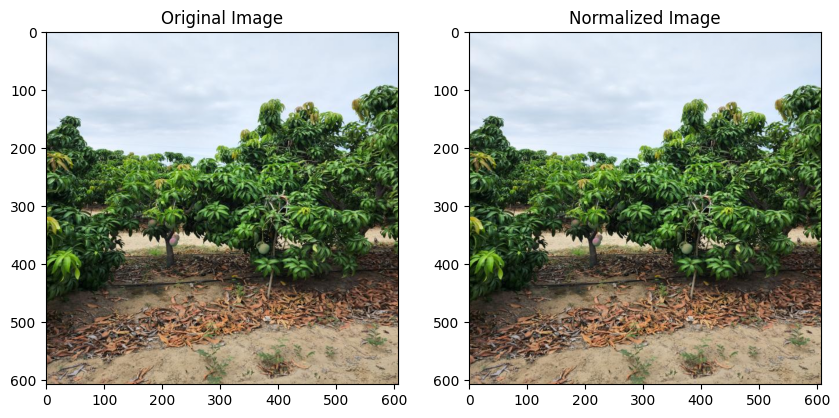

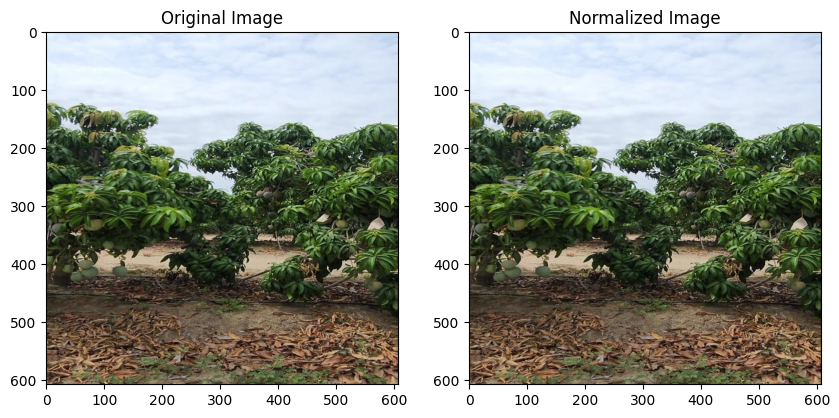

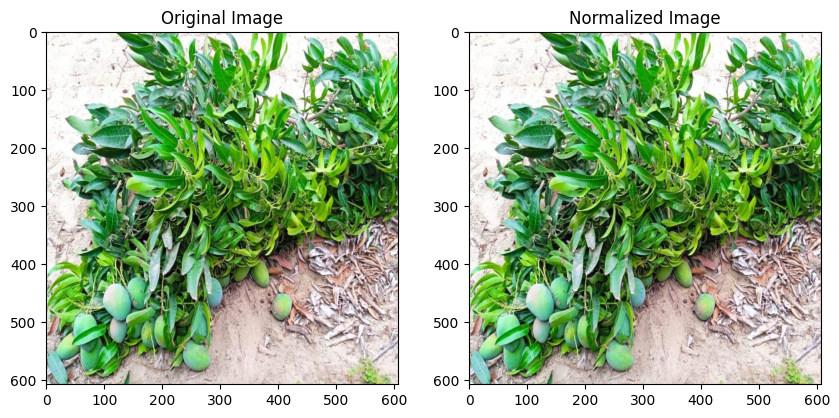

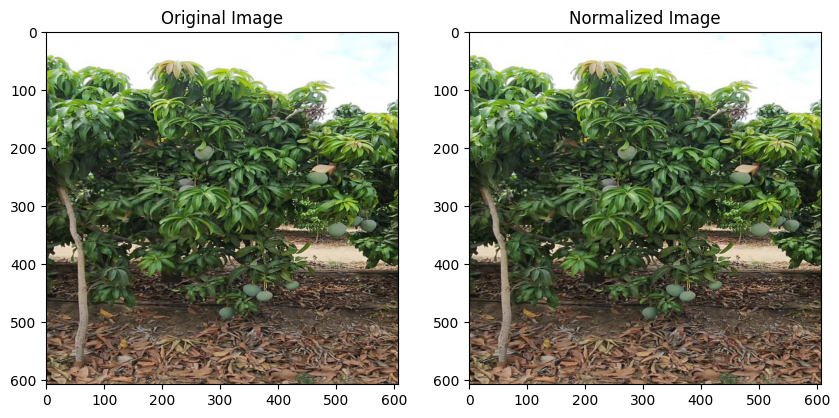

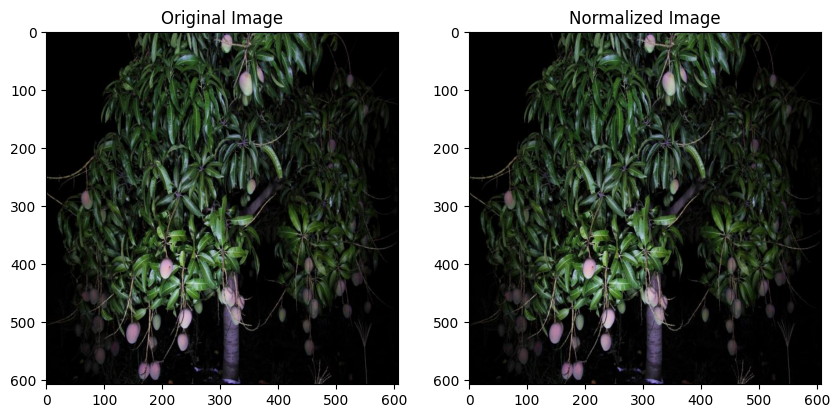

Dataset YAML configuration:
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
Dataset preprocessing completed!


In [5]:
def preprocess_dataset(base_path):
    """
    Preprocess the dataset images to enhance training
    - Apply image normalization
    - Apply image augmentation
    - Check and report dataset statistics
    """
    print("Starting dataset preprocessing...")

    # Set paths
    train_path = os.path.join(base_path, 'train', 'images')
    val_path = os.path.join(base_path, 'valid', 'images')

    # Count datasets and analyze
    train_files = os.listdir(train_path)
    val_files = os.listdir(val_path)

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Sample preprocessing on a few images to test
    sample_images = train_files[:5]  # Process first 5 images as a sample

    for img_file in sample_images:
        img_path = os.path.join(train_path, img_file)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image {img_file}")
            continue

        # Convert BGR to RGB (OpenCV loads as BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize image
        img_norm = img_rgb / 255.0

        # Display original and preprocessed image for verification
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)

        plt.subplot(1, 2, 2)
        plt.title("Normalized Image")
        plt.imshow(img_norm)
        plt.show()

    # Validate dataset YAML file
    with open(os.path.join(base_path, 'data.yaml'), 'r') as f:
        yaml_content = f.read()
        print("Dataset YAML configuration:")
        print(yaml_content)

    # Create a modified YAML file for Ultralytics
    with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
        f.write(f"""
train: {train_path}
val: {val_path}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
        """)

    print("Dataset preprocessing completed!")
    return os.path.join(base_path, 'data.yaml')

# Execute preprocessing
yaml_path = preprocess_dataset('/content/mango_dataset')

# Model Training

Starting model training with YOLOv11 on device: 0...


100%|██████████| 38.8M/38.8M [00:00<00:00, 148MB/s]


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/mango_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=mango_detector_v11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 12.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              


  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1   1642496  ultralytics.nn.modules.block.C3k2            [1024, 512, 1, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1361.2±656.9 MB/s, size: 85.7 KB)


train: Scanning /content/mango_dataset/train/labels... 1529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1529/1529 [00:00<00:00, 1706.06it/s]


train: New cache created: /content/mango_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 697.9±537.4 MB/s, size: 66.1 KB)


val: Scanning /content/mango_dataset/valid/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 1924.64it/s]

val: New cache created: /content/mango_dataset/valid/labels.cache


Plotting labels to runs/detect/mango_detector_v11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/mango_detector_v11
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.54G      1.432      1.187      0.986        288        640: 100%|██████████| 96/96 [00:59<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


                   all         65        649     0.0304      0.773     0.0279     0.0162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.43G      1.414     0.8309     0.9701        185        640: 100%|██████████| 96/96 [00:59<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         65        649      0.736      0.658       0.69        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.41G      1.416     0.8243     0.9658        368        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         65        649      0.757      0.664      0.737      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.58G      1.397     0.8099     0.9671        253        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         65        649      0.785      0.688      0.768      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.45G      1.352     0.7738      0.953        239        640: 100%|██████████| 96/96 [01:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         65        649      0.838      0.715      0.803       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.33G      1.333     0.7426     0.9427        276        640: 100%|██████████| 96/96 [00:59<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         65        649        0.8      0.732      0.798      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.61G      1.329       0.74      0.947        204        640: 100%|██████████| 96/96 [00:58<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         65        649      0.852      0.726      0.826      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.48G      1.307     0.7205     0.9375        447        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         65        649      0.821      0.764      0.847      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.26G      1.296     0.7101     0.9332        307        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         65        649      0.893      0.781      0.876      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.56G      1.276     0.6904     0.9281        658        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         65        649      0.898      0.783      0.877      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.54G      1.285     0.6848     0.9279        472        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         65        649      0.899      0.787      0.878      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.53G       1.26     0.6635     0.9249        181        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         65        649      0.843      0.788      0.867      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.29G      1.253     0.6716     0.9269        312        640: 100%|██████████| 96/96 [00:57<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         65        649      0.858      0.806      0.873      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.42G      1.239     0.6563     0.9216        323        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         65        649      0.886      0.804      0.879      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.41G      1.232     0.6418     0.9182        268        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         65        649      0.891      0.812      0.891      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.27G      1.223     0.6325     0.9131        321        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         65        649      0.878      0.808      0.884      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.54G      1.212     0.6248     0.9124        364        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         65        649      0.888      0.818      0.896      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.47G      1.211     0.6259      0.912        185        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         65        649      0.903      0.826        0.9      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.46G      1.203     0.6169     0.9058        359        640: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         65        649      0.903      0.831      0.895      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.43G        1.2     0.6161      0.914        300        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         65        649      0.899      0.807      0.888      0.597


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.19G       1.19     0.6051     0.9119        284        640: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         65        649      0.877      0.832      0.896      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       8.1G      1.171     0.5893     0.9106        311        640: 100%|██████████| 96/96 [00:56<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         65        649      0.885      0.839      0.906      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.19G      1.169     0.5842     0.9131        192        640: 100%|██████████| 96/96 [00:56<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         65        649      0.888       0.84      0.905      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.04G      1.158     0.5769     0.9078        264        640: 100%|██████████| 96/96 [00:57<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         65        649       0.91      0.806      0.895      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.28G       1.15     0.5691     0.9029        146        640: 100%|██████████| 96/96 [00:56<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         65        649      0.898      0.831      0.906      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.14G      1.142     0.5592     0.9037        195        640: 100%|██████████| 96/96 [00:57<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         65        649      0.906      0.846      0.916       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.05G      1.126     0.5464     0.8982        179        640: 100%|██████████| 96/96 [00:57<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         65        649      0.899      0.843      0.916      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.09G      1.127     0.5432     0.8953        231        640: 100%|██████████| 96/96 [00:57<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         65        649       0.93       0.82      0.911       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.23G      1.116     0.5326     0.8929        173        640: 100%|██████████| 96/96 [00:56<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         65        649      0.934      0.834       0.92      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.05G      1.103     0.5249     0.8913        257        640: 100%|██████████| 96/96 [00:56<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         65        649      0.915      0.837      0.918      0.638



30 epochs completed in 0.522 hours.
Optimizer stripped from runs/detect/mango_detector_v11/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/mango_detector_v11/weights/best.pt, 40.5MB

Validating runs/detect/mango_detector_v11/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


                   all         65        649      0.934      0.834       0.92      0.642
Speed: 0.2ms preprocess, 11.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/mango_detector_v11
Model trained and saved to /content/mango_detector_v11.pt

Training Results:
metrics/precision(B): 0.9341486772938146
metrics/recall(B): 0.8335901386748844
metrics/mAP50(B): 0.9200893588063498
metrics/mAP50-95(B): 0.6419778686404127
fitness: 0.6697890176570065


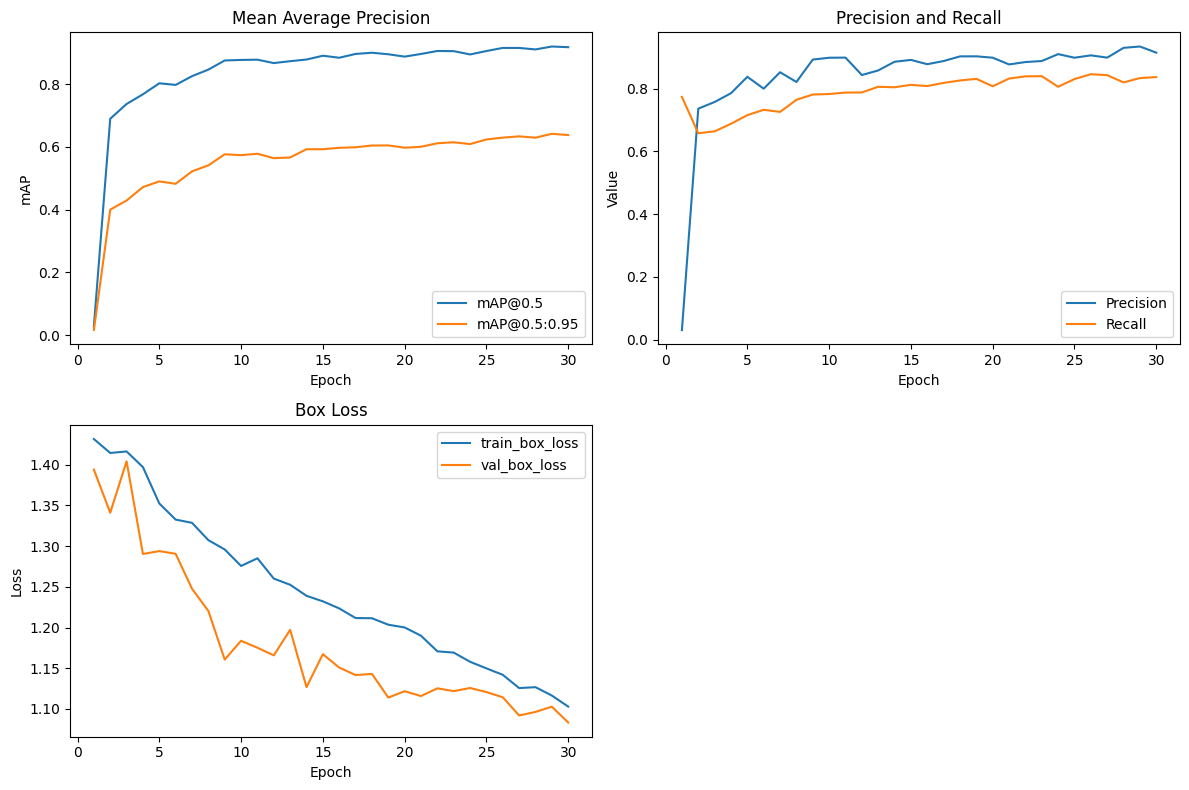

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
def train_model(dataset_yaml, epochs=50, image_size=640, batch_size=16, device=0):
    """
    Train the YOLOv11 model
    """
    print(f"Starting model training with YOLOv11 on device: {device}...")

    model = YOLO('yolo11m.pt')

    # Train the model
    results = model.train(
        data=dataset_yaml,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        name='mango_detector_v11',
        device=device,
        verbose=True
    )

    model_path = '/content/mango_detector_v11.pt'
    best_weights_path = os.path.join(model.trainer.save_dir, 'weights', 'best.pt')

    # Copy best weights to desired path
    if os.path.exists(best_weights_path):
        os.system(f"cp {best_weights_path} {model_path}")
        print(f"Model trained and saved to {model_path}")
    else:
        print(f"Best weights not found at {best_weights_path}")
        alt_path = os.path.join(model.trainer.save_dir, 'weights', 'last.pt')
        if os.path.exists(alt_path):
            os.system(f"cp {alt_path} {model_path}")
            print(f"Last checkpoint saved to {model_path}")
        else:
            print("Could not find model weights to save.")

    # Display training results
    results_dict = results.results_dict if hasattr(results, 'results_dict') else {}
    print("\nTraining Results:")
    for metric, value in results_dict.items():
        print(f"{metric}: {value}")

    # Plot training curves
    try:
        results_csv = os.path.join(model.trainer.save_dir, 'results.csv')
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)

            plt.figure(figsize=(12, 8))

            # mAP
            plt.subplot(2, 2, 1)
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            plt.title('Mean Average Precision')
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.legend()

            # Precision and Recall
            plt.subplot(2, 2, 2)
            plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
            plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
            plt.title('Precision and Recall')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()

            # Losses
            plt.subplot(2, 2, 3)
            plt.plot(df['epoch'], df['train/box_loss'], label='train_box_loss')
            plt.plot(df['epoch'], df['val/box_loss'], label='val_box_loss')
            plt.title('Box Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")

    return model, model_path

# Train the model
try:
    model, model_path = train_model(yaml_path, epochs=5, device=device)
    files.download(model_path)
except Exception as e:
    print(f"Error during training: {e}")
    model_path = '/content/runs/detect/train/weights/best.pt'
    print(f"Using fallback path: {model_path}")

# Metrics

Evaluating model metrics on device: 0...
Successfully loaded model from /content/mango_detector_v11.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2103.4±532.5 MB/s, size: 66.4 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


                   all         65        649      0.934      0.834      0.919      0.641
Speed: 10.8ms preprocess, 29.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val
Validation completed successfully in 7.41 seconds

===== Detection Metrics Summary =====
mAP@0.5: 0.9194
mAP@0.5:0.95: 0.6410
Precision: 0.9341
Recall: 0.8336
F1-Score: 0.8810
Time taken: 7.41 seconds


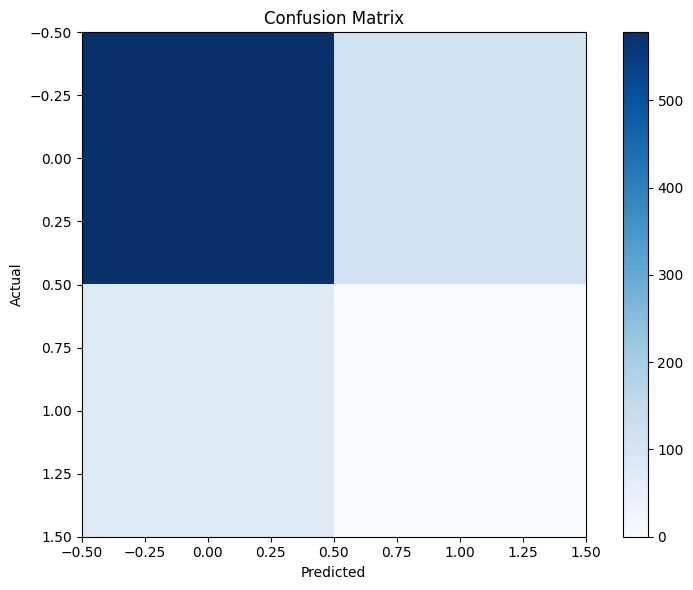


Evaluating on test set (defined in YAML)...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1813.1±1095.5 MB/s, size: 76.2 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


                   all         65        649      0.934      0.834      0.919      0.641
Speed: 4.7ms preprocess, 27.2ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/val2

===== Final Detection Metrics =====
Precision: 0.9341
Recall: 0.8336
F1-Score: 0.8810
mAP@0.5: 0.9194
mAP@0.5:0.95: 0.6410
mAP@0.75: 0.7617
Time taken on test set: 6.60 seconds


In [7]:
def check_model_metrics(model_path, yaml_path, device=0):
    """
    Check and visualize metrics for the trained model
    """
    print(f"Evaluating model metrics on device: {device}...")

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot evaluate metrics.")
            return None

    # Load the trained model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    # Time the validation
    try:
        start_time = time.time()
        results = model.val(data=yaml_path, device=device)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Validation completed successfully in {elapsed_time:.2f} seconds")
    except Exception as e:
        print(f"Error during validation: {e}")
        return None

    # Print metrics summary
    metrics = results.box
    print("\n===== Detection Metrics Summary =====")
    print(f"mAP@0.5: {metrics.map50:.4f}")
    print(f"mAP@0.5:0.95: {metrics.map:.4f}")
    print(f"Precision: {metrics.p[0]:.4f}")
    print(f"Recall: {metrics.r[0]:.4f}")
    print(f"F1-Score: {metrics.f1[0]:.4f}")
    print(f"Time taken: {elapsed_time:.2f} seconds")

    # Confusion matrix plot
    try:
        if hasattr(results, 'confusion_matrix') and results.confusion_matrix is not None:
            conf_matrix = results.confusion_matrix.matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

    return results

# Call the function with model and dataset paths
if 'model_path' in locals():
    model_metrics = check_model_metrics(model_path, yaml_path, device=device)

    # Display metrics on test set specifically
    print("\nEvaluating on test set (defined in YAML)...")
    try:
        model = YOLO(model_path)
        start_time = time.time()
        test_results = model.val(data=yaml_path, device=device, split='val')
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Print full metrics summary from test results
        metrics = test_results.box
        print("\n===== Final Detection Metrics =====")
        print(f"Precision: {metrics.p[0]:.4f}")
        print(f"Recall: {metrics.r[0]:.4f}")
        print(f"F1-Score: {metrics.f1[0]:.4f}")
        print(f"mAP@0.5: {metrics.map50:.4f}")
        print(f"mAP@0.5:0.95: {metrics.map:.4f}")
        print(f"mAP@0.75: {metrics.map75:.4f}")
        print(f"Time taken on test set: {elapsed_time:.2f} seconds")

    except Exception as e:
        print(f"Error evaluating on test set: {e}")
else:
    print("No model path defined. Skipping metrics check.")

# Model Inference

Upload an image for inference:


Saving reference_img.jpg to reference_img.jpg
Successfully loaded model from /content/mango_detector_v11.pt

image 1/1 /content/reference_img.jpg: 448x640 16 Mangos, 46.4ms
Speed: 2.6ms preprocess, 46.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
Inference completed successfully
Found 16 mangoes in the image
Detected Mango with confidence 0.87
Detected Mango with confidence 0.86
Detected Mango with confidence 0.86
Detected Mango with confidence 0.86
Detected Mango with confidence 0.84
Detected Mango with confidence 0.84
Detected Mango with confidence 0.84
Detected Mango with confidence 0.83
Detected Mango with confidence 0.77
Detected Mango with confidence 0.76
Detected Mango with confidence 0.66
Detected Mango with confidence 0.66
Detected Mango with confidence 0.63
Detected Mango with confidence 0.60
Detected Mango with confidence 0.57
Detected Mango with confidence 0.54


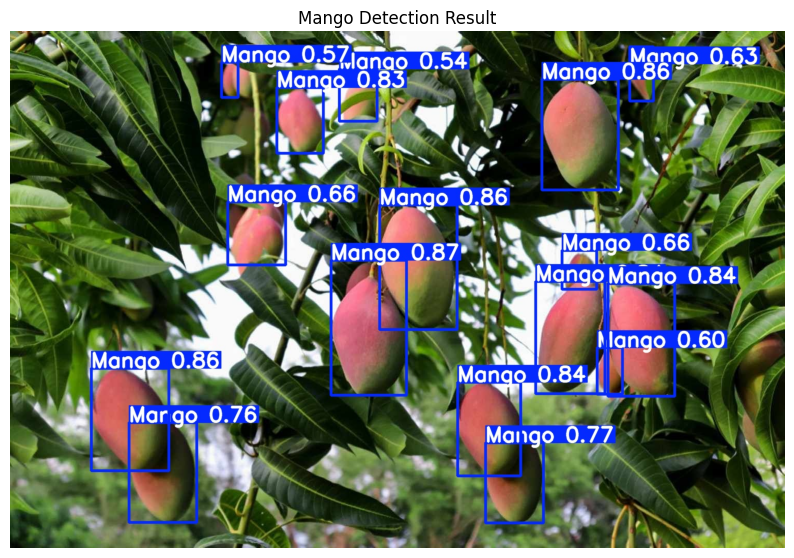

In [10]:
def inference_on_image(model_path, device=0):
    """
    Perform inference on uploaded images using GPU
    """
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        # Try to find the model in possible alternative locations
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]

        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot perform inference.")
            return

    print("Upload an image for inference:")
    uploaded = files.upload()  # Prompt to upload an image

    if not uploaded:
        print("No image uploaded!")
        return

    uploaded_file = list(uploaded.keys())[0]

    # Load model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Run inference with GPU
    try:
        results = model.predict(
            source=uploaded_file,
            conf=0.5,
            save=True,
            device=device
        )
        print("Inference completed successfully")
    except Exception as e:
        print(f"Error during inference: {e}")
        return

    # Display results
    for r in results:
        # Plot detection results
        boxes = r.boxes
        print(f"Found {len(boxes)} mangoes in the image")

        # Display detection details
        for box in boxes:
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            cls_name = model.names[cls]
            print(f"Detected {cls_name} with confidence {conf:.2f}")

    # Show the prediction image
    try:
        # Get the latest predict folder (sorted by creation time)
        predict_dirs = [d for d in os.listdir('runs/detect') if d.startswith('predict')]
        if predict_dirs:
            newest_dir = max(predict_dirs, key=lambda x: os.path.getctime(os.path.join('runs/detect', x)))
            result_image_path = os.path.join('runs', 'detect', newest_dir, uploaded_file)

            if os.path.exists(result_image_path):
                img = cv2.imread(result_image_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(10, 8))
                plt.title("Mango Detection Result")
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()
            else:
                print(f"Result image not found at {result_image_path}")
        else:
            print("No prediction directory found")
    except Exception as e:
        print(f"Error displaying result image: {e}")

# Run inference with the trained model
if 'model_path' in locals():
    try:
        inference_on_image(model_path, device=device)
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("No model path defined. Skipping inference.")